# Quora Question Pairs

##  Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re#use regular expressions to do a find-and-replace

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


import scipy
import xgboost as xgb

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from string import punctuation
from nltk.stem import SnowballStemmer

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm

import pickle
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
#skew measure the asymmetry of the distribution
#Kurtosis measures the sharpness of the peak in the data distribution
from scipy.stats import skew, kurtosis 

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../quora question pairs/train.csv')

train.head()

/Users/syou/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [2]:
test = pd.read_csv('../quora question pairs/test.csv')

test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [3]:
train = train.dropna(how='any').reset_index(drop=True)#If any NAN values are present, drop that row or column

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB



id: the id of a training set question pair  
qid1, qid2: unique ids of each question  
question1, question2: the full text of each question  
is_duplicate: label 0 or 1, 1 is the same meaning,0 is not the same

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   test_id    int64 
 1   question1  object
 2   question2  object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [6]:
#test =test.dropna(how='any').reset_index(drop=True)

<AxesSubplot:title={'center':'distribution of duplicate and no-duplicate question'}, xlabel='is_duplicate'>

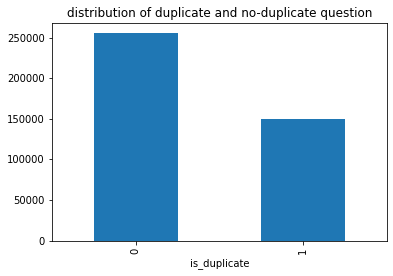

In [7]:
plt.title('distribution of duplicate and no-duplicate question')#1 is the same meaning
train.groupby("is_duplicate")['id'].count().plot.bar()#distribution of duplicate and no-duplicate question

In [8]:
train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [9]:
a = 0
#print first 10 question pairs
for i in range(a, a+10):
    print(train.question1[i])
    print(train.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

# Clean

In [10]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    def pad_str(s):
        return ' '+ s +' '
    
    if pd.isnull(text):
        return ''

    #Clean the text, with the option to stem words.
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    
    # Empty question
    if type(text) != str or text=='':
        return ''

    #remove punctuation, to lowercase text
    text = ''.join([c for c in text if c not in punctuation]).lower()
    
    # Clean the text
    text = re.sub("\'s", " ", text) #we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)

    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    # replace the float numbers with a random number, 
    # it will be parsed as number afterward, and also been replaced with word "number"
    text = re.sub('\.[0-9]+\.[0-9]+', " 87 ", text)
    
    
    return text

In [11]:
train["question1"] = train["question1"].apply(clean)
train["question2"] = train["question2"].apply(clean)

In [12]:
a = 0
for i in range(a, a+10):
    print(train.question1[i])
    print(train.question2[i])
    print()

what is the step by step guid to invest in share market in india
what is the step by step guid to invest in share market

what is the stori of kohinoor kohinoor diamond
what would happen if the indian govern stole the kohinoor kohinoor diamond back

how can i increas the speed of my internet connect while use a vpn
how can internet speed be increas by hack through dns

whi am i mental veri lonely how can i solv it
find the remaind when math2324math is divid by 2423

which one dissolv in water quik sugar salt methan and carbon di oxide
which fish would surviv in salt water

astrology i am a capricorn sun cap moon and cap risingwhat doe that say about me
im a tripl capricorn sun moon and ascend in capricorn what doe this say about me

should i buy tiago
what keep childern activ and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use シ instead of し
when do you use  instead of and

motorola company can i hack my charter mo

In [13]:
test["question1"] = test["question1"].apply(clean)
test["question2"] = test["question2"].apply(clean)

In [14]:
a = 0
for i in range(a, a+10):
    print(test.question1[i])
    print(test.question2[i])
    print()

how doe the surfac pro himself 4 compar with ipad pro
whi did microsoft choos core m3 and not core i3 home surfac pro 4

should i have a hair transplant at age 24 how much would it cost
how much cost doe hair transplant require

what but is the best way to send money from China to the us
what you send money to china

which food not emulsifiers
what food fibre

how aberystwyth start reading
how their can i start reading

how are the two wheeler insur from bharti axa insurance
i admir i am consid of buy insur from them

how can i reduc my belli fat through a diet
how can i reduc my lower belli fat in one month

by scrap the 500 and 1000 rupe notes how is rbi plan to fight against issu black money
how will the recent move to declar 500 and 1000 denomin lewin illeg will curb black money

what are the how best book of all time
what are some of the militari histori book of all time

after 12th year old boy and i had sex with a 12 year old girl with her consent is there anyth wrong
can a 14 o

# Construct  feature  

In [15]:
def wmd(s1, s2):
    s1 = str(s1)
    s1 = str(s1).split()
    s2 = str(s2).split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

def norm_wmd(s1, s2):
    s1 = str(s1).split()
    s2 = str(s2).split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return norm_model.wmdistance(s1, s2)
    
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())
    

In [16]:
#train features
train['len_q1'] = train.question1.apply(lambda x: len(str(x)))#length of q1
train['len_q2'] = train.question2.apply(lambda x: len(str(x)))#length of q2
train['diff_len'] = train.len_q1 - train.len_q2#Difference in the two lengths
train['len_char_q1'] = train.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))#Character length of q1 without spaces
train['len_char_q2'] = train.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))#Character length of q2 without spaces
train['len_word_q1'] = train.question1.apply(lambda x: len(str(x).split()))#Number of words in q1
train['len_word_q2'] = train.question2.apply(lambda x: len(str(x).split()))#Number of words in q2
#Number of common words
train['common_words'] = train.apply(lambda x: len(set(str(x['question1']).split()).intersection(set(str(x['question2']).lower().split()))), axis=1)


In [17]:
#test features
test['len_q1'] = test.question1.apply(lambda x: len(str(x)))#length of q1
test['len_q2'] = test.question2.apply(lambda x: len(str(x)))#length of q2
test['diff_len'] = test.len_q1 - test.len_q2#Difference in the two lengths
test['len_char_q1'] = test.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))#Character length of q1 without spaces
test['len_char_q2'] = test.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))#Character length of q2 without spaces
test['len_word_q1'] = test.question1.apply(lambda x: len(str(x).split()))#Number of words in q1
test['len_word_q2'] = test.question2.apply(lambda x: len(str(x).split()))#Number of words in q2
#Number of common words
test['common_words'] = test.apply(lambda x: len(set(str(x['question1']).split()).intersection(set(str(x['question2']).lower().split()))), axis=1)


In [23]:
#https://www.geeksforgeeks.org/fuzzywuzzy-python-library/
#String Similarity
#calculate the differences between sequences
train['fuzz_qratio'] = train.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_wratio'] = train.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_partial_ratio'] = train.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])),axis=1)
train['fuzz_partial_token_set_ratio'] = train.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])),axis=1)
train['fuzz_partial_token_sort_ratio'] = train.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])),axis=1)
train['fuzz_token_set_ratio'] = train.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
train['fuzz_token_sort_ratio'] = train.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [24]:

test['fuzz_qratio'] = test.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_wratio'] = test.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_partial_ratio'] = test.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])),axis=1)
test['fuzz_partial_token_set_ratio'] = test.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])),axis=1)
test['fuzz_partial_token_sort_ratio'] = test.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])),axis=1)
test['fuzz_token_set_ratio'] = test.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
test['fuzz_token_sort_ratio'] = test.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [25]:
#Embedding
model = api.load('word2vec-google-news-300')
train['wmd'] = train.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)

test['wmd'] = test.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)

norm_model = api.load('word2vec-google-news-300')
#trim memory
norm_model.init_sims(replace=True)
train['norm_wmd'] = train.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

test['norm_wmd'] = test.apply(lambda x: norm_wmd(x['question1'], x['question2']), axis=1)

In [26]:
#sent2vec
train_question1_vectors = np.zeros((train.shape[0], 300))#init data
error_count = 0

for i, q in tqdm(enumerate(train.question1.values)):
    train_question1_vectors[i, :] = sent2vec(q)
    
train_question2_vectors = np.zeros((train.shape[0], 300))
for i, q in tqdm(enumerate(train.question2.values)):
    train_question2_vectors[i, :] = sent2vec(q)


404287it [00:47, 8488.48it/s]
404287it [00:46, 8678.91it/s]


In [27]:
# cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                        np.nan_to_num(train_question2_vectors))]
train['cityblock'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                     np.nan_to_num(train_question2_vectors))]
train['jaccard'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                np.nan_to_num(train_question2_vectors))]
train['canberra'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                   np.nan_to_num(train_question2_vectors))]
train['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                              np.nan_to_num(train_question2_vectors))]
train['minkowski'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                     np.nan_to_num(train_question2_vectors))]
train['braycurtis'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(train_question1_vectors),
                                                     np.nan_to_num(train_question2_vectors))]

train['skew_q1vec'] = [skew(x) for x in np.nan_to_num(train_question1_vectors)]
train['skew_q2vec'] = [skew(x) for x in np.nan_to_num(train_question2_vectors)]
train['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(train_question1_vectors)]
train['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(train_question2_vectors)]

pickle.dump(train_question1_vectors, open('../quora question pairs/train_q1_w2v.pkl', 'wb'), -1)
pickle.dump(train_question2_vectors, open('../quora question pairs/train_q2_w2v.pkl', 'wb'), -1)

train.to_csv('../train_quora_features.csv', index=False)


In [28]:
#test sent2vec
test_question1_vectors = np.zeros((test.shape[0], 300))#init data
error_count = 0

for i, q in tqdm(enumerate(test.question1.values)):
    test_question1_vectors[i, :] = sent2vec(q)
    
test_question2_vectors = np.zeros((test.shape[0], 300))
for i, q in tqdm(enumerate(test.question2.values)):
    test_question2_vectors[i, :] = sent2vec(q)


2345796it [04:32, 8604.84it/s]
2345796it [04:27, 8766.22it/s]


In [29]:
#test
#cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                        np.nan_to_num(test_question2_vectors))]
test['cityblock'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                     np.nan_to_num(test_question2_vectors))]
test['jaccard'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                np.nan_to_num(test_question2_vectors))]
test['canberra'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                   np.nan_to_num(test_question2_vectors))]
test['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                              np.nan_to_num(test_question2_vectors))]
test['minkowski'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                     np.nan_to_num(test_question2_vectors))]
test['braycurtis'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(test_question1_vectors),
                                                     np.nan_to_num(test_question2_vectors))]

test['skew_q1vec'] = [skew(x) for x in np.nan_to_num(test_question1_vectors)]
test['skew_q2vec'] = [skew(x) for x in np.nan_to_num(test_question2_vectors)]
test['kur_q1vec'] = [kurtosis(x) for x in np.nan_to_num(test_question1_vectors)]
test['kur_q2vec'] = [kurtosis(x) for x in np.nan_to_num(test_question2_vectors)]

In [30]:
pickle.dump(test_question1_vectors, open('../quora question pairs/test_q1_w2v.pkl', 'wb'), -1)
pickle.dump(test_question2_vectors, open('../quora question pairs/test_q2_w2v.pkl', 'wb'), -1)

# XGBoost

In [ ]:
test = test.drop(['test_id','question1', 'question2'],axis=1)

In [49]:
X = train.drop(['is_duplicate','question1','question2'], axis=1)
y = train['is_duplicate']

In [50]:
X_train,X_valid,y_train,y_valid = train_test_split(X, y, test_size = 0.2)

In [51]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)

In [126]:
#parameters for xgboost
xgb_params = {'eval_metric':'logloss',
              'objective': 'binary:logistic',
              'eta': 0.02,            #learning rate
              'max_depth': 5,      #10,5,3
             }
num_boost_round = 2500

In [127]:
%%time
watchlist = [(d_train, 'train'), (d_valid, 'valid')] 
xgb_model = xgb.train(xgb_params,
                      d_train,
                      num_boost_round,
                      evals = watchlist,
                      early_stopping_rounds = 300,
                      verbose_eval = 10)

[0]	train-logloss:0.68774	valid-logloss:0.68761
[10]	train-logloss:0.64237	valid-logloss:0.64215
[20]	train-logloss:0.61019	valid-logloss:0.60995
[30]	train-logloss:0.58659	valid-logloss:0.58623
[40]	train-logloss:0.56847	valid-logloss:0.56817
[50]	train-logloss:0.55448	valid-logloss:0.55424
[60]	train-logloss:0.54368	valid-logloss:0.54348
[70]	train-logloss:0.53522	valid-logloss:0.53506
[80]	train-logloss:0.52859	valid-logloss:0.52851
[90]	train-logloss:0.52333	valid-logloss:0.52333
[100]	train-logloss:0.51900	valid-logloss:0.51911
[110]	train-logloss:0.51545	valid-logloss:0.51570
[120]	train-logloss:0.51246	valid-logloss:0.51282
[130]	train-logloss:0.51016	valid-logloss:0.51062
[140]	train-logloss:0.50802	valid-logloss:0.50860
[150]	train-logloss:0.50635	valid-logloss:0.50701
[160]	train-logloss:0.50490	valid-logloss:0.50565
[170]	train-logloss:0.50365	valid-logloss:0.50450
[180]	train-logloss:0.50252	valid-logloss:0.50347
[190]	train-logloss:0.50140	valid-logloss:0.50244
[200]	train

[1630]	train-logloss:0.45948	valid-logloss:0.47249
[1640]	train-logloss:0.45933	valid-logloss:0.47242
[1650]	train-logloss:0.45918	valid-logloss:0.47235
[1660]	train-logloss:0.45909	valid-logloss:0.47231
[1670]	train-logloss:0.45895	valid-logloss:0.47226
[1680]	train-logloss:0.45883	valid-logloss:0.47220
[1690]	train-logloss:0.45870	valid-logloss:0.47214
[1700]	train-logloss:0.45855	valid-logloss:0.47207
[1710]	train-logloss:0.45841	valid-logloss:0.47200
[1720]	train-logloss:0.45828	valid-logloss:0.47194
[1730]	train-logloss:0.45816	valid-logloss:0.47190
[1740]	train-logloss:0.45804	valid-logloss:0.47184
[1750]	train-logloss:0.45792	valid-logloss:0.47179
[1760]	train-logloss:0.45778	valid-logloss:0.47174
[1770]	train-logloss:0.45765	valid-logloss:0.47168
[1780]	train-logloss:0.45755	valid-logloss:0.47165
[1790]	train-logloss:0.45742	valid-logloss:0.47159
[1800]	train-logloss:0.45725	valid-logloss:0.47150
[1810]	train-logloss:0.45709	valid-logloss:0.47143
[1820]	train-logloss:0.45695	va

In [128]:
%%time
d_test = xgb.DMatrix(test)
pred_test = xgb_model.predict(d_test)


CPU times: user 1min 49s, sys: 1.7 s, total: 1min 50s
Wall time: 17 s


In [129]:
sub = pd.DataFrame()
sub.index.name = 'test_id'
sub['is_duplicate'] = pred_test
sub.to_csv('submission.csv')